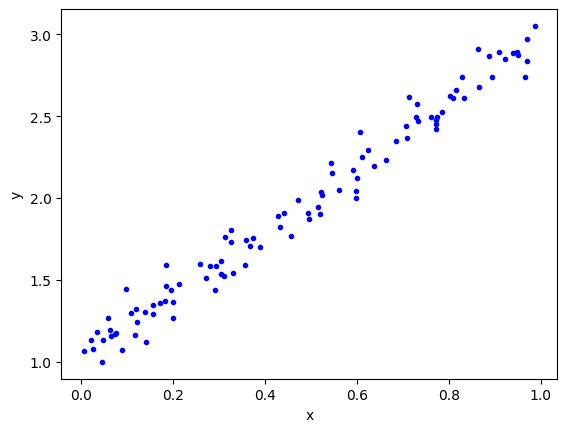

In [1]:
import numpy as np

true_b = 1
true_w = 2
N = 100 # number of data 

np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon #data generation

# Plot the data
import matplotlib.pyplot as plt
plt.plot(x, y, 'b.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

```python
@
```
The above operator is the matrix multiplication

In [5]:
# Shuffles the indicies
idx = np.arange(N) # Return evenly spaced values within a given interval.
split_index = int(N * 0.8) # train-validation split

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

#sci-kit learn으로 위의 코드 구현
'''
from sklearn.model_selection import train_test_split    
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
'''

## Gradient Descent for Linear Regression

In [20]:
@timer
def train_model_numpy(lr=0.1, epochs=1000):
    #intialize parameters: 딥러닝 성능 좌우
    b = np.random.randn(1)
    w = np.random.randn(1)
    
    for epoch in range(epochs):
        #Loss computation
        y_hat = b + w * x_train
        error = (y_hat - y_train)
        mse_loss = np.mean(error ** 2)
        
        #Gradient computation
        b_grad = 2 * np.mean(error)
        w_grad = 2* np.mean(error * x_train)
        b, w = b - lr * b_grad, w - lr * w_grad

    return b, w

Numpy의 장점은 1차원코드로 vectorization 구현

In [19]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        computation_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {computation_time} sec")
        return result
    return wrapper

In [21]:
b_hat, w_hat = train_model_numpy(lr=0.1, epochs=1000)
print("b_estimate:{}, w_estimate:{}".format(b_hat, w_hat))

Execution time of train_model_numpy: 0.03129911422729492 sec
b_estimate:[1.0234136], w_estimate:[1.93680757]


## PyTorch

In [24]:
import torch

# create tensor at CPU
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

# create tensor at GPU 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).to(device)
y_train_tensor = torch.as_tensor(y_train).to(device)

- Numpy는 intel server CPU에서 최적화됨
- PyTorch는 GPU에서도 최적화됨  

- 'cuda': nvidia GPU
- GPU텐서는 CPU텐서와 <font color=red>통신 </font>없이는 서로 계산이 불가능하므로 주의!

## Gradient Descent by PyTorch

In [30]:
def train_model_torch(lr=0.1, epochs=1000):
    #Initialize parameters
    b = torch.randn(1, requires_grad=True, device=device)
    w = torch.randn(1, requires_grad=True, device=device)
    
    for epoch in range(epochs):
        # loss computation
        y_hat = b + w * x_train_tensor
        error = (y_hat - y_train_tensor)
        mse_loss = torch.mean(error ** 2)
        # Gradient Computation and descent
        mse_loss.backward()
        with torch.no_grad():
            b -= lr * b.grad
            w -= lr * w.grad
            
        b.grad.zero_() #초기화 한 후 for문 초반으로 돌아감
        w.grad.zero_()
    return b, w

- requires_grad: 파라미터에 대한 auto_grad기능 구현. 학습대상임을 명시 
- dtype default: float32, float $\equiv$ float 64
- with torch.no_grad(): PyTorch의 자동 미분 엔진에서 추적되지 않도록 함.
- x = x + y $\Rightarrow$ : 저장주소 바뀜
- x += y $\Rightarrow$ : 저장주소 동일 (*in-place operation*)
- zero_: underbar가 *in-place operation*를 의미

In [26]:
   # Auxiliary code (without in-place operator)
'''
        b.retain_grad(), w.retain_grad()
    return b, w
'''

'\n     b.retain_grad(), w.retain_grad()\n return b, w\n'

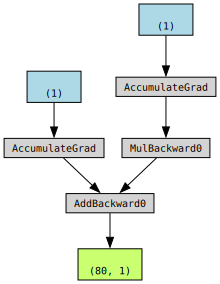

In [40]:
b,w = train_model_torch()
# from torchviz import make_dot
y_hat = b + w * x_train_tensor
make_dot(y_hat)

## Library

In [33]:
import torch.optim as optim
import torch.nn as nn

In [36]:
def train_model_torch(lr=0.1, epochs=1000):
    #Initialize parameters
    b = torch.randn(1, requires_grad=True, device=device)
    w = torch.randn(1, requires_grad=True, device=device)
    parameters = [b, w]
    optimizer = optim.SGD(parameters, lr=0.1)
    mse_loss = nn.MSELoss() #MSE Loss 대신 error loss or Huber loss로 대체 가능
    
    for epoch in range(epochs):
        # loss computation
        y_hat = b + w * x_train_tensor
        loss = mse_loss(y_hat, y_train_tensor)
        # Gradient Computation and descent
        loss.backward()
        optimizer.step() #gradient descent step 한번
        optimizer.zero_grad() #gradient 초기화
    return b, w

In [43]:
b_hat, w_hat = train_model_torch()
print("b_estimate:{}, w_estimate:{}".format(b_hat, w_hat))

b_estimate:tensor([1.0234], requires_grad=True), w_estimate:tensor([1.9368], requires_grad=True)


## Quiz 1
- PyTorch로 추정한 parameter를 이용해서 test데이터에서 MSE error를 계산 코드 구현

In [50]:
x_val_tensor = torch.as_tensor(x_val).to(device)
y_val_tensor = torch.as_tensor(y_val).to(device)

In [56]:
y_hat = b_hat + w_hat * x_val_tensor
mse_loss = nn.MSELoss()
loss_val = mse_loss(y_hat, y_val_tensor)
print(loss_val)

tensor(0.0098, dtype=torch.float64, grad_fn=<MseLossBackward0>)


## Quiz 2
- Slack에 올라온 데이터셋을 fitting하는 함수의 parameter 추정

In [44]:
# open pickle file
import pickle
with open('/Users/parkmark/Desktop/ECA/pytorch study/week2/quiz_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [100]:
print(data.keys())

dict_keys(['x', 'y'])


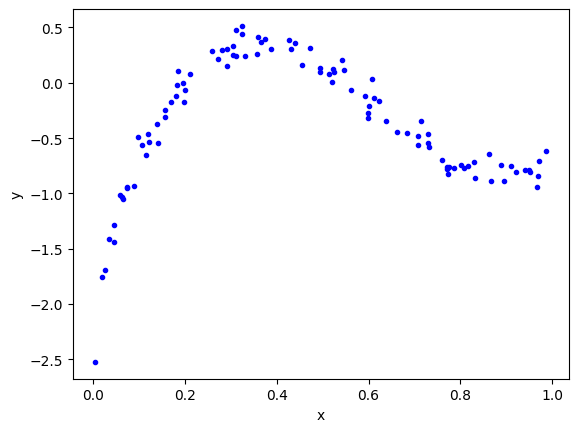

In [101]:
# plot data
import matplotlib.pyplot as plt
plt.plot(data['x'], data['y'], 'b.')        
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [124]:
N = len(data['x'])
# Shuffles the indicies
idx = np.arange(N) # Return evenly spaced values within a given interval.
split_index = int(N * 0.8) # train-validation split

train_idx = idx[:split_index]
val_idx = idx[split_index:]

# Generates train and validation sets
x_train, y_train = data['x'][train_idx], data['y'][train_idx]
x_val, y_val = data['x'][val_idx], data['y'][val_idx]

In [125]:
x_train_tensor_2 = torch.tensor(x_train, dtype=torch.float).to(device)
y_train_tensor_2 = torch.tensor(y_train, dtype=torch.float).to(device)
x_val_tensor_2 = torch.as_tensor(x_val, dtype=torch.float).to(device)
y_val_tensor_2 = torch.as_tensor(y_val, dtype=torch.float).to(device)

In [126]:
@timer
def train_model_torch_2(lr=0.1, epochs=1000):
    #Initialize parameters
    b = torch.randn(1, requires_grad=True, device=device)
    w = torch.randn(1, requires_grad=True, device=device)
    w2 = torch.randn(1, requires_grad=True, device=device)
    parameters = [b, w, w2]
    optimizer = optim.SGD(parameters, lr=0.1)
    mse_loss = nn.MSELoss() #MSE Loss 대신 error loss or Huber loss로 대체 가능
    
    for epoch in range(epochs):
        # loss computation
        y_hat = b + w * x_train_tensor_2 + w2 * x_train_tensor_2 ** 2
        loss = mse_loss(y_hat, y_train_tensor_2)
        # Gradient Computation and descent
        loss.backward()
        optimizer.step() #gradient descent step 한번
        optimizer.zero_grad() #gradient 초기화
    return b, w, w2

In [127]:
b_hat_2, w_hat_2, w2_hat_2 = train_model_torch_2(lr=0.1, epochs=1000)

Execution time of train_model_torch_2: 0.29196977615356445 sec
b_estimate:tensor([-0.6409], requires_grad=True), w_estimate:tensor([2.2616], requires_grad=True), w2_estimate:tensor([-2.5682], requires_grad=True)


In [128]:
y_hat_2 = b_hat_2 + w_hat * x_train_tensor_2 + w2_hat_2 * x_train_tensor_2 ** 2

In [129]:
#MSE Train loss
mse_loss = nn.MSELoss()
loss_train = mse_loss(y_hat_2, y_train_tensor_2)

tensor(0.2273, grad_fn=<MseLossBackward0>)


In [130]:
#MSE Test loss
y_hat_test_2 = b_hat_2 + w_hat * x_val_tensor_2 + w2_hat_2 * x_val_tensor_2 ** 2
mse_loss = nn.MSELoss()
loss_val_2 = mse_loss(y_hat_test_2, y_val_tensor_2)

tensor(0.2064, grad_fn=<MseLossBackward0>)


In [133]:
print("b_estimate:{}, w_estimate:{}, \n w2_estimate:{}".format(b_hat_2, w_hat_2, w2_hat_2))
print(f"train loss: {loss_train}, test loss: {loss_val_2}")

b_estimate:tensor([-0.6409], requires_grad=True), w_estimate:tensor([2.2616], requires_grad=True), 
 w2_estimate:tensor([-2.5682], requires_grad=True)
train loss: 0.2273416519165039, test loss: 0.20636531710624695
